In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from tqdm.notebook import tqdm

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [2]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        self.A = nn.Tanh()
        
    def forward(self, input_data, hidden):
        hidden = self.W.forward(torch.cat([input_data, hidden], dim=1))
        hidden = self.A(hidden)
        return hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [3]:
input_feature_size = 6
hidden_size=5
batch_size=1

In [4]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [5]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [6]:
print(new_hidden.shape)

torch.Size([1, 5])


In [7]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]]
new_hidden:  [[-0.4006685  -0.12000882  0.02915544  0.14349274  0.00113   ]]


In [8]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[-0.46758664 -0.21893781 -0.02700323  0.15147689 -0.00778677]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [9]:
!mkdir data

Џ®¤Ї ЇЄ  Ё«Ё д ©« data г¦Ґ бгйҐбвўгҐв.


Загружаем данные

In [10]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Populating the interactive namespace from numpy and matplotlib


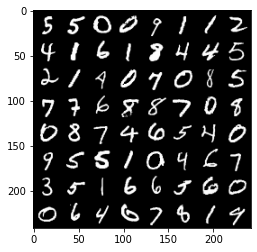

In [11]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [12]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [13]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0286,  0.1100, -0.0666, -0.0179,  0.0331,  0.0766,  0.0535,  0.0194,
         -0.0269, -0.0088],
        [-0.0241,  0.1146, -0.0688, -0.0181,  0.0317,  0.0730,  0.0537,  0.0188,
         -0.0249, -0.0119],
        [-0.0240,  0.1045, -0.0637, -0.0168,  0.0307,  0.0725,  0.0574,  0.0215,
         -0.0248,  0.0009],
        [-0.0461,  0.1061, -0.0612, -0.0144,  0.0411,  0.0840,  0.0409,  0.0258,
         -0.0400, -0.0158],
        [-0.0235,  0.1042, -0.0653, -0.0167,  0.0341,  0.0712,  0.0558,  0.0230,
         -0.0268,  0.0005],
        [-0.0262,  0.1071, -0.0643, -0.0181,  0.0378,  0.0719,  0.0529,  0.0209,
         -0.0287, -0.0064],
        [-0.0266,  0.1009, -0.0561, -0.0129,  0.0360,  0.0684,  0.0555,  0.0181,
         -0.0197, -0.0002],
        [-0.0468,  0.1001, -0.0300, -0.0186,  0.0385,  0.0553,  0.0493,  0.0245,
         -0.0076, -0.0044],
        [-0.0290,  0.1096, -0.0439, -0.0159,  0.0253,  0.0545,  0.0402,  0.0088,
         -0.0282, -0.0047],
        [-0.0231,  

## Обучаем

In [15]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [16]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.9239 | Train Accuracy: 68.64
Epoch:  1 | Loss: 0.4878 | Train Accuracy: 84.41
Epoch:  2 | Loss: 0.2923 | Train Accuracy: 91.45
Epoch:  3 | Loss: 0.2197 | Train Accuracy: 93.66
Epoch:  4 | Loss: 0.1835 | Train Accuracy: 94.76
Epoch:  5 | Loss: 0.1627 | Train Accuracy: 95.37
Epoch:  6 | Loss: 0.1420 | Train Accuracy: 95.95
Epoch:  7 | Loss: 0.1353 | Train Accuracy: 96.19
Epoch:  8 | Loss: 0.1299 | Train Accuracy: 96.34
Epoch:  9 | Loss: 0.1192 | Train Accuracy: 96.59


### Смотрим что на тесте

In [17]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.30


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [18]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

def spacy_tokenize(x):
    return [tok.text for tok in tokenizer(x)]

In [19]:
import torch
import spacy
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize=spacy_tokenize)
LABEL = data.LabelField(dtype=torch.float)

In [20]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

In [21]:
#for i in range(len(train_data)):
#    train_data[i].text = train_data[i].text[:140] 

In [22]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [23]:
print(vars(train_data.examples[0]))

{'text': ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of', '

In [24]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [25]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=5000)
LABEL.build_vocab(train_data)

In [26]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 5002
Unique tokens in LABEL vocabulary: 2


In [27]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'unk_index': None,
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [28]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 201637), ('a', 108267), ('and', 106782), ('of', 99982), ('to', 92808), ('is', 72305), ('in', 59801), ('I', 45880), ('that', 45107), ('this', 40094), ('it', 38059), ('/><br', 35752), ('was', 32706), ('as', 29668), ('with', 29022), ('for', 28896), ('The', 23668), ('but', 23604), ('on', 21550), ('movie', 21368)]


* stoi (string to int)
* itos (int to string)

In [29]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'I']


In [30]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [31]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

In [32]:
next(iter(train_iterator)).label
next(iter(train_iterator)).text

tensor([[ 161,    9, 1087,  ...,   18,  586,   49],
        [   3,   96, 3292,  ..., 1985,  155,    7],
        [   0,  119,  373,  ...,    5,    0,    3],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')

In [33]:
next(iter(train_iterator))
next(iter(train_iterator)).text

tensor([[ 132,  329,  254,  ...,    9,    0,    9],
        [   0, 4200,  134,  ...,  202,   74,  155],
        [  13,  183,   26,  ...,   10,   11,  559],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [34]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        batch_size = x.size(1)
        embedded = self.embedding(x)

        #embedded.shape = [sent len, batch size, emb dim]
        #output.shape = [sent len, batch size, hid dim]
        #hidden.shape = [1, batch size, hid dim]
        _, hidden = self.rnn(embedded)
        
        out = self.fc(hidden.squeeze(0))
        return torch.sigmoid(out)

In [35]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, layers, dropout=0.5, bidirectional=True):
        super().__init__()

        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim, num_layers=layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(2 * hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        embedded = self.embedding(input)
        
        _, (hidden, _) = self.lstm(embedded)
 
        out = torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.sigmoid(out)
        return out

In [36]:
INPUT_DIM = 5002
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
N_EPHOCS = 10
N_LAYERS = 2

In [37]:
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
print(model)

LSTM(
  (embedding): Embedding(5002, 100)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [38]:
def accuracy(preds, target, batch_size):
    preds = torch.round(preds)
    accuracy = (preds == target).sum() / batch_size
    return accuracy.item()

In [39]:
for epoch in tqdm(range(N_EPHOCS)):
    
    train_running_loss = 0.0
    train_acc = 0.0
    
    val_running_loss = 0.0
    val_acc = 0.0
    
    model.train()
    
    for i, data in enumerate(train_iterator):
        optimizer.zero_grad()
        
        inputs = data.text
        labels = data.label
        
        outputs = model(inputs).squeeze(1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += accuracy(outputs, labels, BATCH_SIZE)
        
        val_inputs = next(iter(valid_iterator)).text
        val_labels = next(iter(valid_iterator)).label
        val_outputs = model(val_inputs).squeeze(1)
        val_running_loss += criterion(val_outputs, val_labels).detach().item()
        val_acc += accuracy(val_outputs, val_labels, BATCH_SIZE)
        
    model.eval()
    print('Epoch:  %d | Train loss: %.4f | Train accuracy: %.2f | Validation loss: %.4f | Validation accuracy: %.2f'
          %(epoch, train_running_loss / i, train_acc / i, val_running_loss / i, val_acc / i))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0 | Train loss: 0.6845 | Train accuracy: 0.56 | Validation loss: 0.6778 | Validation accuracy: 0.56
Epoch:  1 | Train loss: 0.6378 | Train accuracy: 0.64 | Validation loss: 0.6153 | Validation accuracy: 0.67
Epoch:  2 | Train loss: 0.6112 | Train accuracy: 0.68 | Validation loss: 0.6168 | Validation accuracy: 0.67
Epoch:  3 | Train loss: 0.5227 | Train accuracy: 0.75 | Validation loss: 0.5813 | Validation accuracy: 0.73
Epoch:  4 | Train loss: 0.4293 | Train accuracy: 0.81 | Validation loss: 0.5426 | Validation accuracy: 0.77
Epoch:  5 | Train loss: 0.3616 | Train accuracy: 0.85 | Validation loss: 0.5068 | Validation accuracy: 0.80
Epoch:  6 | Train loss: 0.3075 | Train accuracy: 0.88 | Validation loss: 0.4420 | Validation accuracy: 0.83
Epoch:  7 | Train loss: 0.2720 | Train accuracy: 0.90 | Validation loss: 0.4262 | Validation accuracy: 0.85
Epoch:  8 | Train loss: 0.2308 | Train accuracy: 0.91 | Validation loss: 0.4326 | Validation accuracy: 0.85
Epoch:  9 | Train loss: 0.19